# Abstract
Today, we will be using the PUMS dataset to predict employment of members in the state of Michigan that are within the dataset, as well as auditing for racial bias. The process we will be using is first implementing a SVC to predict employment status based on features excluding race and the target variable (employment status), then evaluating our findings based on statistical definitions of fairness, such as calibration, error rate balance, and statistical parity of each racial group (white, black, or other). Through this process, I evaluated my model as passing both approximate cabliration and error rate balance tests but failing the statistical parity test, with white people having a higher rate of being predicted to be employed than black people or other people of a self-identified racial identity. Overall, I note in the conclusion the predicted impact of implementing this predictor model at large and note potential issues/uncomforabilites.

# Fetching PUMS Dataset

First we will download the data that we are working with:

In [2]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MI"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000064,3,1,2907,2,26,1013097,8,60,...,9,0,12,9,11,9,0,9,10,12
1,P,2018GQ0000154,3,1,1200,2,26,1013097,92,20,...,92,91,93,95,93,173,91,15,172,172
2,P,2018GQ0000158,3,1,2903,2,26,1013097,26,54,...,26,52,3,25,25,28,28,50,51,25
3,P,2018GQ0000174,3,1,1801,2,26,1013097,86,20,...,85,12,87,12,87,85,157,86,86,86
4,P,2018GQ0000212,3,1,2600,2,26,1013097,99,33,...,98,96,98,95,174,175,96,95,179,97


# Feature Selection

For the purposes of our demonstration, we only need a small subset of the features offered.

In [3]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,60,15.0,5,17,1,NaN,1,1.0,4.0,1,1,2,2,1.0,1,2,6.0
1,20,19.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,1,6.0
2,54,18.0,3,16,1,NaN,1,1.0,4.0,4,1,2,2,1.0,1,1,6.0
3,20,18.0,5,17,2,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,6.0
4,33,18.0,5,16,2,NaN,1,3.0,4.0,2,1,2,2,2.0,1,1,6.0


For the purposes of predicting employment status and auditing for racial bias we are going to exclude the features `ESR` (employment status) and `RAC1P` (race) from the set that we are going to train a machine learning model on.

In [4]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

# Constructing the "Basic Problem"

In [5]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

# Train Test Split
In order to accurately evaluate the accuracy of machine learning models, we are going to train the model using the data from X_train, and test the model using the data from X_test. Note we are seperating the sensitive feature `RAC1P` into the `group` array which we will use later on when we audit the model for racial bias.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Data Analysis Questions
In order to properly analyze our data, we are first going to answer a few questions regarding the types of people in our dataset that will gives us more insight we when attempt to audit for racial bias.

In [ ]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

Here, before we attempt to answer the questions, turn our X_train array back into a pandas DataFrame to make the analysis of the dataset easier.

1. How many people are in the dataset?

In [9]:
individuals = df.shape[0]
individuals

79535

2. What proportion of these people have a target label == `1`? Where `1` whould correspond with the person being employed and `0` would correspond with the person being unemployed.

In [10]:
employed = df[df["label"] == True].shape[0] / individuals
employed

0.44297479097252784

3. Of these individuals, how many are in each group?

In [11]:
group1_proportion = df[df["group"] == 1].shape[0] / individuals
group2_proportion = df[df["group"] == 2].shape[0] / individuals
group3_proportion = df[df["group"] >= 3].shape[0] / individuals
groups_series = pd.Series({'white': group1_proportion, 'black' : group2_proportion, 'other' : group3_proportion})

groups_dataframe = pd.DataFrame(groups_series, columns=['groups_series'])
groups_dataframe


,groups_series
white,0.847614
black,0.086515
other,0.065870


4. In each group, what proportion of indiviuals have a target label == 1? (Meaning they are employed)

In [12]:
group1_employed, group1_unemployed = df[(df["group"] == 1) & (df["label"] == True)].shape[0], df[(df["group"] == 1) & (df["label"] == False)].shape[0]
group2_employed, group2_unemployed = df[(df["group"] == 2) & (df["label"] == True)].shape[0], df[(df["group"] == 2) & (df["label"] == False)].shape[0]
group3_employed, group3_unemployed = df[(df["group"] == 3) & (df["label"] == True)].shape[0], df[(df["group"] == 3) & (df["label"] == False)].shape[0]
group1_employ_proportion = pd.Series({'employed' : group1_employed / individuals, 'unemployed' : group1_unemployed / individuals})
group2_employ_proportion = pd.Series({'employed' : group2_employed / individuals, 'unemployed' : group2_unemployed / individuals})
group3_employ_proportion = pd.Series({'employed' : group2_employed / individuals, 'unemployed' : group3_unemployed / individuals})
group_employ_dataframe = pd.DataFrame({'white': group1_employ_proportion, 'black': group2_employ_proportion, 'other': group3_employ_proportion})
group_employ_dataframe

,white,black,other
employed,0.385516,0.029924,0.029924
unemployed,0.462098,0.056591,0.003407


5. What are the intersectional trends of people in the dataset that are employed? For example, race (`RAC1P`) and sex (`SEX`)?

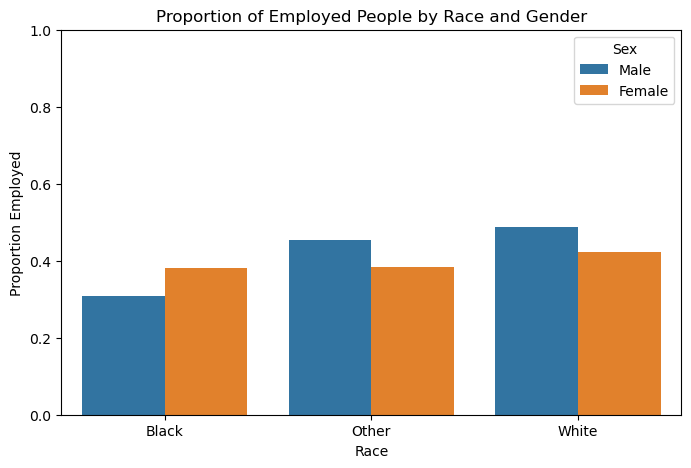

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_barplot = df.copy()

df_barplot['RACE_CAT'] = df_barplot['group'].map(lambda x: 'White' if x == 1 else ('Black' if x == 2 else 'Other'))

employment_rates = df_barplot.groupby(['RACE_CAT', 'SEX'])['label'].mean().reset_index()
employment_rates['SEX'] = employment_rates['SEX'].map({1: 'Male', 2: 'Female'})

plt.figure(figsize=(8, 5))
sns.barplot(employment_rates, x="RACE_CAT", y='label', hue="SEX")

plt.xlabel("Race")
plt.ylabel("Proportion Employed")
plt.title("Proportion of Employed People by Race and Gender")
plt.ylim(0, 1)  
plt.legend(title="Sex")
plt.show()



# Data Analysis Conclusion
With these findings, we gather some important information that can help inform our racial bias audit. We see that the dataset is heavily dominated with white people which may skew our predictor model from being able to accurately predict the employment status of other racial groups. We also see that white people within the dataset have a higher proportion of employed group members than other racial groups, so our predictor model should likely mirror that disparity.

# Training SVC Model
Now that we have gathered information, it is time to train predictor model using the training dataset. We will be using a Support Vector Classifier (SVC) to predict employment status of the members of our dataset.

Above we have created the dataframes X_train, X_test, y_train, y_test, so now we must plug them into the sklearn SVC function. We use sklearn `make_pipeline` function to first run the dataset through the `StandardScaler` function before moving to our SVC (support vector classifier) machine learning model.

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVC(C=10))
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

Now we use the `model.predict()` function on X_test and store the result in `y_hat`. Now, `y_hat` is a boolean array which contains all the predictions (employed == True, unemployed == False) for each row of the X_test dataset.

In [129]:
y_hat

array([ True,  True,  True, ...,  True,  True, False], shape=(19884,))

# Model Auditing

Now that we have created the predictor model, we can now audit the model, first concerning ourself on its overall accurracy. Below, we ask a few questions that will give us an idea of the accuracy of the model.

## Overall Measures
1. What is the overall accuracy of the model?
2. What is the positive predictive value (PPV) of the model?
3. What are the overall false negative and flase positive rates (FNP and FPR) for the model?

### Overall Acurracy of Model

To get the overall accuracy of the model, get a boolean vector through `(y_hat == y_test)` which will give an array of truth or false values corresponding to the equality of the prediction and the actual value. To get the percentage of the correct predictions in the boolean vector, we take the mean with the `mean()` function.

In [75]:
model_accuracy = (y_hat == y_test).mean()
model_accuracy

np.float64(0.825940454636894)

The overall accuracy of the model is approximately 82.5%

### PPV of the Model

To get the positive predictive value of the model, we divide the number of true positives (TP) by the total number of positive predictions (TP + FP) 

In [16]:
from sklearn.metrics import confusion_matrix

confusion_array = confusion_matrix(y_test, y_hat)
confusion_array

array([[8744, 2269],
       [1192, 7679]])

In [17]:
TP = confusion_array[0][0]
FN = confusion_array[0][1]
FP = confusion_array[1][0]
TN = confusion_array[1][1]

PPV = TP / (TP+FP)
PPV

np.float64(0.8800322061191627)

### FPR and FNR of the Model
Similarly, we can use the confusion matrix to get the FPR and FNR of the model

In [18]:
# False positive rate calculation
FPR = FP / (FP + TN)
FPR

np.float64(0.1343704204711983)

In [19]:
# False negative rate calculation
FNR = FN / (FN + TP)
FNR

np.float64(0.2060292381730682)

## By-Group Measures

Now that we have observed the overall accuracy of the model, we now concern ourselves with the accuracy of the model as it pertains to the racial groups (white, black, other) that exist within the dataset. Below we ask a few questions:

1. What is the accuracy of your model on each subgroup
2. What is the PPV of your model on each subgroup?
3. What are the FNR and FPR on each subgroup?


To answer question 1, we can make a summary table displaying the accuracy of the model on each subgroup

In [58]:
accuracy_group_1 = (y_hat[group_test == 1] == y_test[group_test == 1]).mean()
accuracy_group_2 = (y_hat[group_test == 2] == y_test[group_test == 2]).mean()
accuracy_group_3 = (y_hat[group_test == 3] == y_test[group_test == 3]).mean()

subgroup_accuracy = pd.Series({"White": accuracy_group_1,"Black": accuracy_group_2, "Other": accuracy_group_3})
sub_acc_df = pd.DataFrame(subgroup_accuracy, columns=["Accuracy"])
sub_acc_df


,Accuracy
White,0.827000
Black,0.816878
Other,0.793651


To answer question 2, we can return to the idea of confusion matrices, making one for each subgroup and calculating the PPV as TP (True Positive Predictions) / TP + FP (False Positive Predictions).

In [61]:
white_confusion_array = confusion_matrix((y_test[group_test == 1]), y_hat[group_test == 1])  
black_confusion_array = confusion_matrix((y_test[group_test == 2]), y_hat[group_test == 2])
other_confusion_array = confusion_matrix((y_test[group_test == 3]), y_hat[group_test == 3])

white_PPV = white_confusion_array[0][0] / (white_confusion_array[0][0] + white_confusion_array[1][0])
black_PPV = black_confusion_array[0][0] / (black_confusion_array[0][0] + black_confusion_array[1][0])
other_PPV = other_confusion_array[0][0] / (other_confusion_array[0][0] + other_confusion_array[1][0])

group_PPV = pd.Series({"white": white_PPV,"black": black_PPV, "other": other_PPV})
group_PPV_df = pd.DataFrame(group_PPV, columns=["PPV"])
group_PPV_df

,PPV
white,0.877176
black,0.899512
other,0.906250


To answer question 3, we can take a simiar approach as shown above, only switching the values that we are taking from the confusion matrix 

In [63]:
white_confusion_array = confusion_matrix((y_test[group_test == 1]), y_hat[group_test == 1])  
black_confusion_array = confusion_matrix((y_test[group_test == 2]), y_hat[group_test == 2])
other_confusion_array = confusion_matrix((y_test[group_test == 3]), y_hat[group_test == 3])

white_FNR = white_confusion_array[0][1] / (white_confusion_array[0][1] + white_confusion_array[0][0])
white_FPR = white_confusion_array[1][0] / (white_confusion_array[1][0] + white_confusion_array[1][1])

black_FNR = black_confusion_array[0][1] / (black_confusion_array[0][1] + black_confusion_array[0][0])
black_FPR = black_confusion_array[1][0] / (black_confusion_array[1][0] + black_confusion_array[1][1])

other_FNR = other_confusion_array[0][1] / (other_confusion_array[0][1] + other_confusion_array[0][0])
other_FPR = other_confusion_array[1][0] / (other_confusion_array[1][0] + other_confusion_array[1][1])

group_FNR = pd.Series({"white": white_FNR,"black": black_FNR, "other": other_FNR})
group_FPR = pd.Series({"white": white_FPR,"black": black_FPR, "other": other_FPR})



group_FPR_FNR_df = pd.DataFrame({"FNR": group_FNR, "FPR": group_FPR})
group_FPR_FNR_df

,FNR,FPR
white,0.208654,0.130886
black,0.198957,0.155589
other,0.256410,0.125000


## Bias Measures

Now that we have evaluted the overall accuracy and the accuracy within groups of the model, we now use statistical definitions of fairness to ascertain a sense of the models "fairness". Below, we ask a few questions:

1. Is the model approximately calibrated?
2. Does the model satisfy approximate error rate balance?
3. Does the model satisfy statistical parity?

To answer question 1, we can get the calibration of the model by evulating it by group. If the model is approximately calibrated, then its accuracy at predicting in each group * people in the dataset should roughly equal the number of the people of that particular group in the dataset.

In [85]:
(int(X_test.shape[0] * accuracy_group_1), X_test[group_test == 1].shape[0]), 

((16444, 16815),)

In [86]:
(int(X_test.shape[0] * accuracy_group_2), X_test[group_test == 2].shape[0])

(16242, 1813)

In [87]:
(int(X_test.shape[0] * accuracy_group_3), X_test[group_test == 3].shape[0])

(15780, 126)

We can see that for group 1 the model is highly calibrated however for groups 2 and 3 the model is not.

To answer question 2, we must see if the true positive and false positive rates between the three groups are roughly equal. As we have done before, we display a dataframe that will allow us to analyze the relationship of the true postive and false positive rates between groups. Because we have already computed the false positive rate for each group, we only need to compute the true positive rate.

In [91]:
white_confusion_array = confusion_matrix((y_test[group_test == 1]), y_hat[group_test == 1])  
black_confusion_array = confusion_matrix((y_test[group_test == 2]), y_hat[group_test == 2])
other_confusion_array = confusion_matrix((y_test[group_test == 3]), y_hat[group_test == 3])

white_TPR = white_confusion_array[0][0] / (white_confusion_array[0][0] + white_confusion_array[0][1])

black_TPR = black_confusion_array[0][0] / (black_confusion_array[0][0] + black_confusion_array[0][1])

other_TPR = other_confusion_array[0][0] / (other_confusion_array[0][0] + other_confusion_array[0][1])

group_TPR = pd.Series({"white": white_TPR,"black": black_TPR, "other": other_TPR})



group_TPR_FPR_df = pd.DataFrame({"TPR": group_TPR, "FPR": group_FPR})
group_TPR_FPR_df

,TPR,FPR
white,0.791346,0.130886
black,0.801043,0.155589
other,0.743590,0.125000


We can see that between the 3 groups, the TPR and FPR are roughly the same, with the TPR for each group around 75-56% and the FPR around 13%.

To answer question 3 and evaluate the model for statistical parity, we must evaluate if the probability of positive prediction (this person is predicted to be employed) is the same across the different groups (black, white, other).

In [103]:
prob_white = X_test[(group_test == 1) & (y_hat == 1)].shape[0] / X_test[group_test == 1].shape[0] 
prob_black = X_test[(group_test == 2) & (y_hat == 1)].shape[0] / X_test[group_test == 2].shape[0] 
prob_other = X_test[(group_test >= 3) & (y_hat == 1)].shape[0] / X_test[group_test >= 3].shape[0] 
prob_series = pd.Series({"white": prob_white, "black": prob_black, "other": prob_other})
prob_df = pd.DataFrame(prob_series, columns=["Probability of Employed Prediction"])
prob_df

,Probability of Employed Prediction
white,0.511448
black,0.434639
other,0.445860


We can see here that model does not pass the test of statistical parity, as the `black` and `other` groups have roughly the same percentage, however the `white` group is ahead of both by roughly 7 percent.

We will conclude our visual demonstration of the fairness of this model by showing the relationship between the FPR and FNR of each group as well as the possible FNR and FPR values, depicted by lines showing the relationship between the FPR and FNR.

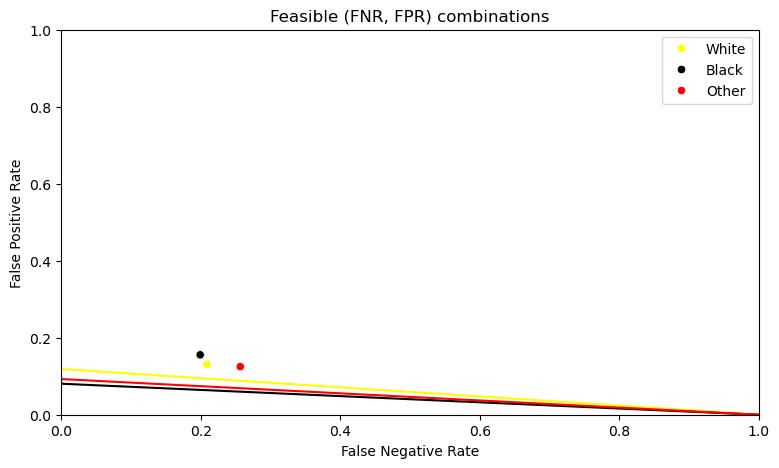

In [127]:
import seaborn as sns
import matplotlib.pyplot as pyplot

#FPR and FNR for each group
FPR_groups = [white_FPR, black_FPR, other_FPR]
FNR_groups = [white_FNR, black_FNR, other_FNR]

#prevalance percentage for each group
white_p = X_test[(group_test == 1) & (y_test == 1)].shape[0] / X_test[group_test == 1].shape[0]
black_p = X_test[(group_test == 2) & (y_test == 1)].shape[0] / X_test[group_test == 2].shape[0]
other_p = X_test[(group_test >= 3) & (y_test == 1)].shape[0] / X_test[group_test >= 3].shape[0]
 
group_PPV = min(white_PPV, black_PPV, other_PPV)

#line of feasible FPR and FNR values for each group
fnr_values = np.linspace(0, 1, 100)
white_fpr_values = (white_p / (1 - white_p)) * ((1 - group_PPV) / group_PPV) * (1 - fnr_values)
black_fpr_values = (black_p / (1 - black_p)) * ((1 - group_PPV) / group_PPV) * (1 - fnr_values)
other_fpr_values = (other_p / (1 - other_p)) * ((1 - group_PPV) / group_PPV) * (1 - fnr_values)

pyplot.figure(figsize=(9, 5))
pyplot.title("Feasible (FNR, FPR) combinations")
pyplot.xlim(0, 1)
pyplot.xlabel("False Negative Rate")
pyplot.ylim(0, 1)
pyplot.ylabel("False Positive Rate")

group_labels = ["White", "Black", "Other"]
palette = {"White": "yellow", "Black": "black", "Other": "red"}

sns.scatterplot(x=FNR_groups, y=FPR_groups, hue = group_labels, palette=palette)
sns.lineplot(x=fnr_values, y = white_fpr_values, color="yellow")
sns.lineplot(x=fnr_values, y = black_fpr_values, color="black")
sns.lineplot(x=fnr_values, y = other_fpr_values, color="red")

pyplot.show()

# Balancing the FNR and FPR

This plot could also assist in answering the following question: If the classifier threshold is tuned so that FPR is equal between groups, how much would be need to change the FNR?

As shown by the graph, we would need to move the points up or down (depending on which FPR we want to align with) to have equal FPR's across groups. This would then change each groups FNR, which we can evaluate by equalizing the FPRs. 

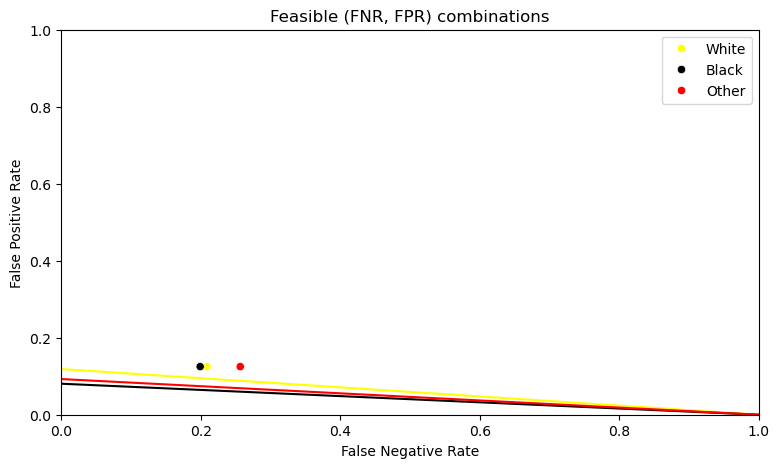

In [132]:
min_FPR = min(white_FPR, black_FPR, other_FPR)
FPR_groups = [min_FPR, min_FPR, min_FPR]

pyplot.figure(figsize=(9, 5))
pyplot.title("Feasible (FNR, FPR) combinations")
pyplot.xlim(0, 1)
pyplot.xlabel("False Negative Rate")
pyplot.ylim(0, 1)
pyplot.ylabel("False Positive Rate")

group_labels = ["White", "Black", "Other"]
palette = {"White": "yellow", "Black": "black", "Other": "red"}

sns.scatterplot(x=FNR_groups, y=FPR_groups, hue = group_labels, palette=palette)
sns.lineplot(x=fnr_values, y = white_fpr_values, color="yellow")
sns.lineplot(x=fnr_values, y = black_fpr_values, color="black")
sns.lineplot(x=fnr_values, y = other_fpr_values, color="red")

pyplot.show()

pyplot.show()

# Concluding Discussion
To conclude our discussion auditing the fairness of this model that predicts employment status, I will answer a few questions regarding the overall fairness concerns and impact of this particular predictor model.

1. What groups of people stand to benefit from a system that is able to predict a person's employment status?

I believe that a predictor of employment status could be used for good by the government and companies aimed at getting the unemployed employed or simply want to find potential workers by using the model to find areas where unemployment is likely prevalent and develop resources to get more people employed. 

2. Based on the bias audit, what could be the impact of deploying the model for large-scale prediction in commmerical or governmental settings?

I feel that based on the bias audit conducted, the model is mostly accurate in its predictions, is approximately calibrated and has an approximate error rate balance, so use for large-scale prediction should have a positive impact, if the goal of the predictions is to find areas where people do not have jobs and work to give them jobs. This could also, however, negatively impact certain neighborhoods / demographics that have a large population of predicted unemployment, whereby stores may not want to open in those areas, or goverment/commerical forces make delibrate moves that make the lives of those people more difficult.

3. Based on the bias audit, do you feel that the model displays problematic bias?

Because the model did not pass the statistical parity auditing test, with the rate of positive predictions (predicting said person is employed) for white people because statistically higher that black or racially self-identified people, the model could reinforce existing racial disparities in employment and therefore displays possible problematic bias.

4. Beyond bias, are there other potential problems associated with deployment of the model that feel uncomfortable? How could those problems be addressed?

Beyond bias, I feel that because this predictor model is a black box, justification is not provided to those predicted to be employed or unemployed and that to me is uncomfortable. Because the prediction the model makes could have an impact on individual lives if this were implemented at a wide-scale on a goverment level, I would hope an implmentation to appeal or justify the predictions made by the model would be in place, and non-computer generated tasks could also aid in producing accurate predictions.